In [7]:
!pip install PyEpics

In [1]:
import os
import epics
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import multiprocessing
import time

## Constant

### Packet and event definitions

A packet in a data file may contain the following valid 8-byte values:

TYPE | HI QWORD | LO QWORD | NOTE
:-:|:-:|:-:|:-
Packet counter | PKT_CNTR | 0x00000000 | PKT_CNTR can be any 8-digit hex value.
SOF | 0xFEEDFACE | FRAM_NUM | FRAM_NUM can be any 8-digit hex value.<br>Only appears as the first or the second quadword value in the first packet/data file.
Event | EVENT_DATA | TIMESTAMP | EVENT_DATA can be any 8-digit hex number <= 0x7FFF.<br>TIMESTAMP can be any 8-digit hex number >= 0x1000
EOF | NUM_LOST_EVT | 0xDECAFBAD | NUM_LOST_EVT can be any value.<br>Only appears as the last quadword value of a packet/data file.


In [2]:
SOF = 0xFEEDFACE
EOF = 0xDECAFBAD
SOF_HI = 0xFEED
SOF_HI = 0xFACE
EOF_HI = 0xDECA
EOF_LO = 0xFBAD


NUM_CHIPS = 12
NUM_CHIP_CHANS = 32

MCA_SIZE = 4096
TDC_SIZE = 1024

NUM_CHANS = NUM_CHIPS * NUM_CHIP_CHANS

# Event format
CHIP_START_BIT = 27
CHIP_WIDTH     = 4
CHAN_START_BIT = 22
CHAN_WIDTH     = 5
ADDR_START_BIT = CHAN_START_BIT
ADDR_WIDTH     = CHIP_WIDTH+CHAN_WIDTH
TD_START_BIT   = 12
TD_WIDTH       = 10
PD_START_BIT   = 0
PD_WIDTH       = 12
CHIP_MASK = ((1 << CHIP_WIDTH) -1) << CHIP_START_BIT
CHAN_MASK = ((1 << CHAN_WIDTH) -1) << CHAN_START_BIT
ADDR_MASK = ((1 << ADDR_WIDTH) -1) << ADDR_START_BIT
TD_MASK = ((1 << TD_WIDTH) -1) << TD_START_BIT
PD_MASK = ((1 << PD_WIDTH) -1) << PD_START_BIT

## Variables

In [7]:
ca = False

Sys = 'det'
Dev = '1'

#datafile_dir = '/data/year/month/day/runno/'
year = 2024
month = 2
day = 7
runno = 42
fn = 'test'
#df_dir = '/data/' + '/'.join(map(str,[year, month, day, runno])) + '/'
#df_dir = '/'.join(['/data'] + list(map(str,[year, month, day, runno])))
df_dir = '/data/' + str(year) + '/' + str(month).zfill(2) + '/' + str(day).zfill(2) + '/' + str(runno) + '/'
print(df_dir)

/data/2024/02/07/42/


### Global variables that store event information

In [8]:
chips = []
chans = []
addrs = []
tds   = []
pds   = []
timestamps = []
time_diff  = []
metadata   = []

#td_addr         = [[[]for _ in range(NUM_CHIP_CHANS)] for _ in range(NUM_CHIPS)]
#pd_addr         = [[[]for _ in range(NUM_CHIP_CHANS)] for _ in range(NUM_CHIPS)]
#timestamps_addr = [[[]for _ in range(NUM_CHIP_CHANS)] for _ in range(NUM_CHIPS)]
#time_diff_addr  = [[[]for _ in range(NUM_CHIP_CHANS)] for _ in range(NUM_CHIPS)]
lengths_addr    = [[[]for _ in range(NUM_CHIP_CHANS)] for _ in range(NUM_CHIPS)]
metadata_addr   = [[[]for _ in range(NUM_CHIP_CHANS)] for _ in range(NUM_CHIPS)]

## FUNCTION DEFINITIONS

### Function: get_file_info(ca=False)

Get data file related information.

In [9]:
def get_file_info(ca=False):
    global fn
    global runno
    global df_dir
    if ca:
        df_dir_pv = epics.PV(Sys+Dev+'.DATAFILE_DIR')
        df_dir = fn_pv.get()
        fn_pv = epics.PV(Sys+Dev+'.FNAM')
        fn = fn_pv.get()
        runno_pv = epics.PV(Sys+Dev+'.RUNNO')
        runno = fn_pv.get()
    run = f'{runno:010d}'
    return df_dir, fn, run

### Function: list_files_in_directory(directory, filename, runno)

Get all the files in the directory that are generated in the specific run.

In [10]:
def list_files_in_directory(directory, filename, runno):
    pattern = f'{filename}.{runno}.(\d{{10}})\\.bin'
    with os.scandir(directory) as entries:
        for entry in entries:
            if entry.is_file() and re.search(pattern, entry.name):
                yield entry.name
            #entry.close()

### Function: read_word(data, start_index)

Read a 4-byte word data.

In [11]:
##===============================================================
## Read a 4-byte word data
def read_word(data, start_index):
    return int.from_bytes( data[start_index:start_index + 4],
                           byteorder='big',
                           signed=False )

### Function: parse_event(word)

In [12]:
def parse_event(word):
    global CHIP_MASK
    global CHIP_START_BIT
    global CHAN_MASK
    global CHAN_START_BIT
    global TD_MASK
    global TD_START_BIT
    global PD_MASK
    global PD_START_BIT
    
    chip = (word & CHIP_MASK) >> CHIP_START_BIT
    chan = (word & CHAN_MASK) >> CHAN_START_BIT
    addr = (chip << (CHAN_WIDTH)) | chan
    td   = (word & TD_MASK)   >> TD_START_BIT
    pd   = (word & PD_MASK)   >> PD_START_BIT
    return chip, chan, addr, td, pd

### Function: read_data()

Read data from file into lists.

In [13]:
def read_data(filename):
    
    global chips
    global chans
    global addrs
    global tds
    global pds
    global timestamps
    global time_diff
    global metadata
    global timestamps_addr
    global time_diff_addr
    global metadata_addr
    
    print('Reading {filename}...')
    
    wait_for_ts = False # the next word should be event data
        
    with open(filename, 'rb') as file:
        binary_data = file.read()

    data_size = len(binary_data)
    
    first_dword = True

    '''
    sof = read_word(binary_data, 0)
    if sof != SOF:
        print("Wrong SOF: 0x{sof}. 0x{SOF} expected.")
        print(hex(sof))
        frame_num = None  # the following word won't be the frame number
        i = 0             # expect event data from the beginning
    else:
        frame_num = read_word(binary_data, 4)
        i = 8
    '''

    
    while True:

        if i >= data_size:
            break

        word = int.from_bytes(binary_data[i:i + 4], byteorder='big', signed=False)
        i += 4
        
        #print(hex(word))
        
        if first_dword:
            event = word
            first_dword = False
        else:
            if event < 0x80000000 and word > 0x7FFFFFFF:  # regular event_data + timestamp
                first_dword = True
                chip, chan, addr, td, pd = parse_event(event)
                timestamps.append(word)
                chips.append(chip)
                chans.append(chan)
                addrs.append(addr)
                tds.append(td)
                pds.append(pd)
                metadata.append({'seq':i, 'event':event, 'td':td, 'pd':pd, 'chip':chip, 'chan':chan, 'timestamp':word})
                metadata_addr[chip][chan].append({'seq':i, 'event':event, 'td':td, 'pd':pd, 'timestamp':word})
                
            elif (event==SOF) and (i<=16):  # SOF + frame_num 
                first_dword = True
            
            elif (word==EOF) and i==data_size:  # EOF
                packet_loss_count = event
                break
                
            elif (event > 0x7FFFFFFF) and (word > 0x7FFFFFFF):   # lost two event data
                first_dword = True                               # keep looking for data
                            
            elif (event < 0x80000000) and (word < 0x80000000):   # lost one timestamp
                event = word                                     # keep looking for timestamp
                
            elif word == 0:
                if i < datasize-8: # packet_counter + 0-padding
                    first_dword = True
                else:              # missing timestamp for the current event, 0s are num_lost_event, expect EOF
                    event = 0
                    
                
        '''
        if word<0x80000000:
            if word != 0:
                if not wait_for_ts:  # this is the event data
                    wait_for_ts = True
                    chip, chan, addr, td, pd = parse_event(word)
                    event = word
                else:
                    print(f'Missing timestamp at i = {hex(i)}. {chip = }, {chan = }, {td = }, {pd = }')
                #print(f'{i = }, {chip = }, {chan = }, event = {hex(event)}')
            else:
                print(f'All 0s at {hex(i)}')
        else: # this is timestamp
            if wait_for_ts:
                timestamps.append(word)
                chips.append(chip)
                chans.append(chan)
                addrs.append(addr)
                tds.append(td)
                pds.append(pd)
                #print(f'{i = }, {chip = }, {chan = }, event = {hex(event)}')
                #timestamps_addr[chip][chan].append(word)
                #td_addr[chip][chan].append(td)
                #pd_addr[chip][chan].append(pd)
                metadata.append({'seq':i, 'event':event, 'td':td, 'pd':pd, 'chip':chip, 'chan':chan, 'timestamp':word})
                metadata_addr[chip][chan].append({'seq':i, 'event':event, 'td':td, 'pd':pd, 'timestamp':word})
                
                wait_for_ts = False
            else:
                print(f'Missing event at {i}')
        '''
      
    '''
    packet_loss_count = int.from_bytes(binary_data[i:i + 4], byteorder='big', signed=False)
    eof = int.from_bytes(binary_data[i+4:i + 8], byteorder='big', signed=False)
    
    if eof!=EOF:
        if wait_for_ts:
            if packet_loss_count>0x80000000:  # got timestamp
                timestamps.append(word)
                timestamps_addr[chip][chan].append(word)
                wait_for_ts = not wait_for_ts
            else:                # got event
                print(f"Missing timestamp at {i}")
                chips.pop()
                chans.pop()
                addrs.pop()
    '''
    
    print('All data read from {filename}.')

### Function: calc_spectra(filename)

In [14]:
def calc_spectra(filename, mca, tdc):
    #print(f'Processing {filename}...')
    
    with open(filename, 'rb') as file:
        binary_data = file.read()

    data_size = len(binary_data)
    
    first_dword = True
    
    i = 0
    
    while True:

        if i >= data_size:
            break

        word = int.from_bytes(binary_data[i:i + 4], byteorder='big', signed=False)
        i += 4
        
        if first_dword:
            event = word
            first_dword = False
        else:
            if event < 0x80000000 and word > 0x7FFFFFFF:  # regular event_data + timestamp
                first_dword = True
                chip, chan, addr, td, pd = parse_event(event)
                
                if pd > MCA_SIZE:
                    pd = MCA_SIZE
                if td > TDC_SIZE:
                    td = TDC_SIZE
                if (chip>=NUM_CHIPS or chan>=NUM_CHIP_CHANS):
                    print(f'event = {hex(event)}, timestamp = {hex(word)}')
                    print(f'{chip = }, {chan = }, {pd = }, {td = }')
                    #raise Exception('Invalid event data!')
                    return -1
                mca[chip*32+chan][pd] += 1
                tdc[chip*32+chan][td] += 1
                                
            elif (event==SOF) and (i<=16):  # SOF + frame_num 
                first_dword = True
            
            elif (word==EOF) and i==data_size:  # EOF
                packet_loss_count = event
                break
                
            elif (event > 0x7FFFFFFF) and (word > 0x7FFFFFFF):   # lost two event data
                first_dword = True                               # keep looking for data
                            
            elif (event < 0x80000000) and (word < 0x80000000):   # lost one timestamp
                event = word                                     # keep looking for timestamp
                
            elif word == 0:
                if i < datasize-8: # packet_counter + 0-padding
                    first_dword = True
                else:              # missing timestamp for the current event, 0s are num_lost_event, expect EOF
                    event = 0

    return 0

In [15]:
def calc_spectra_ret(filename):
    #print(f'Processing {filename}...')

    mca = [[0 for _ in range(MCA_SIZE)] for _ in range(NUM_CHANS)]
    tdc = [[0 for _ in range(TDC_SIZE)] for _ in range(NUM_CHANS)]

    mca = np.zeros((NUM_CHANS, MCA_SIZE))
    tdc = np.zeros((NUM_CHANS, TDC_SIZE))
        
    with open(filename, 'rb') as file:
        binary_data = file.read()

    data_size = len(binary_data)
    
    first_dword = True
    
    i = 0
    
    while True:

        if i >= data_size:
            break

        word = int.from_bytes(binary_data[i:i + 4], byteorder='big', signed=False)
        i += 4
        
        if first_dword:
            event = word
            first_dword = False
        else:
            if event < 0x80000000 and word > 0x7FFFFFFF:  # regular event_data + timestamp
                first_dword = True
                chip, chan, addr, td, pd = parse_event(event)
                
                if pd > MCA_SIZE:
                    pd = MCA_SIZE
                if td > TDC_SIZE:
                    td = TDC_SIZE
                if (chip>=NUM_CHIPS or chan>=NUM_CHIP_CHANS):
                    print(f'event = {hex(event)}, timestamp = {hex(word)}')
                    print(f'{chip = }, {chan = }, {pd = }, {td = }')
                    #raise Exception('Invalid event data!')
                    return -1, mca, tdc
                mca[chip*32+chan][pd] += 1
                tdc[chip*32+chan][td] += 1
                                
            elif (event==SOF) and (i<=16):  # SOF + frame_num 
                first_dword = True
            
            elif (word==EOF) and i==data_size:  # EOF
                packet_loss_count = event
                break
                
            elif (event > 0x7FFFFFFF) and (word > 0x7FFFFFFF):   # lost two event data
                first_dword = True                               # keep looking for data
                            
            elif (event < 0x80000000) and (word < 0x80000000):   # lost one timestamp
                event = word                                     # keep looking for timestamp
                
            elif word == 0:
                if i < datasize-8: # packet_counter + 0-padding
                    first_dword = True
                else:              # missing timestamp for the current event, 0s are num_lost_event, expect EOF
                    event = 0

    return 0, mca, tdc

### Function: time_analysis(metadata, timestamps, min_interval, max_interval, time_diff)

Process the timestamps:

- Calculate the number of overall timestamps/events;

- Check if two successive events are to close.

In [16]:
def time_analysis(metadata, timestamps, min_interval, max_interval, time_diff):
    print('Starting data analysis...')
    #for i in range(len(timestamps) - 1):
    for i in range(len(metadata) - 1):
        diff = metadata[i+1]['timestamp'] - metadata[i]['timestamp']
        time_diff.append(diff)
        if abs(diff)>max_interval:
            print(f"Successive event interval too large @{hex(metadata[i]['seq'])} {metadata[i]['timestamp']}/{hex(metadata[i]['timestamp'])} and {metadata[i+1]['timestamp']}/{hex(metadata[i+1]['timestamp'])}. Timestamp overflow?")
        #    print(f'Successive event interval too large @{hex(i*8)} {timestamps[i]}/{hex(timestamps[i])} and {timestamps[i+1]}/{hex(timestamps[i+1])}.')
    #length = len(timestamps)
    print('Done')

### Function: time_addr_analysis(metadata_addr)

In [17]:
def time_addr_analysis(metadata_addr):
    print('Analyzing time for each address...')
    
    lengths_addr    = [[[]for _ in range(NUM_CHIP_CHANS)] for _ in range(NUM_CHIPS)]
    
    for i in range(NUM_CHIPS):
        for j in range(NUM_CHIP_CHANS):
            print(f'Number of events @[{i}][{j}]:', end='')
            
            length = len(metadata_addr[i][j])
            lengths_addr[i][j] = length
            print(f"{length}")
            if length==0:
                print(f'    No data for [{i}][{j}]')
                continue
            
            metadata_addr[i][j][0]['time_diff'] = 0
            for k in range(len(metadata_addr[i][j]) - 1):
                diff = metadata_addr[i][j][k+1]['timestamp'] - metadata_addr[i][j][k]['timestamp']
                metadata_addr[i][j][k+1]['time_diff'] = diff
                if (abs(diff) < min_interval):
                    print(f"    Channel[{i}][{j}]: event interval too small between" \
                          f"    {metadata_addr[i][j][k]['seq']} (t={metadata_addr[i][j][k]['timestamp']}) and" \
                          f"    {metadata_addr[i][j][k+1]['seq']} (t={metadata_addr[i][j][k+1]['timestamp']}")
                    
    #lengths = [item for lengths_chip in lengths_addr for item in lengths_addr]
    lengths = [item for lengths_chip in lengths_addr for item in lengths_chip]
    print(lengths)
    plt.plot(lengths)

### Function: plot_spectra(spectra, m, n)

In [26]:
def plot_spectra(spectra):
    data = np.array(spectra)

    # Create a heatmap using Matplotlib
    plt.imshow(data, cmap='YlOrRd', interpolation='nearest', aspect='auto')
    plt.colorbar(label='Color Scale')

    # Optionally, add axis labels and a title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('2D List Heatmap')

    plt.savefig("mca.png") 
    # Show the heatmap
    plt.show()

## Start of processing

### Global variables that store event information

In [22]:
chips = []
chans = []
addrs = []
tds   = []
pds   = []

timestamps = []
time_diff  = []
metadata   = []

mca = [[0 for _ in range(MCA_SIZE)] for _ in range(NUM_CHANS)]
tdc = [[0 for _ in range(TDC_SIZE)] for _ in range(NUM_CHANS)]

#td_addr         = [[[]for _ in range(NUM_CHIP_CHANS)] for _ in range(NUM_CHIPS)]
#pd_addr         = [[[]for _ in range(NUM_CHIP_CHANS)] for _ in range(NUM_CHIPS)]
#timestamps_addr = [[[]for _ in range(NUM_CHIP_CHANS)] for _ in range(NUM_CHIPS)]
#time_diff_addr  = [[[]for _ in range(NUM_CHIP_CHANS)] for _ in range(NUM_CHIPS)]
lengths_addr    = [[[]for _ in range(NUM_CHIP_CHANS)] for _ in range(NUM_CHIPS)]
metadata_addr   = [[[]for _ in range(NUM_CHIP_CHANS)] for _ in range(NUM_CHIPS)]

In [23]:
if __name__ == '__main__':
    datafile_dir, filename, run = get_file_info()
    print(f'{datafile_dir = }, {filename = }, {runno = }')
    #====================================================================

datafile_dir = '/data/2024/02/07/42/', filename = 'test', runno = 42


In [24]:
    #====================================================================
    # Single thread processing
#    sp_start_time = time.time()
    for file in list_files_in_directory(datafile_dir, filename, run):
        file_full = datafile_dir + '/' + file
        print(file_full)
        #read_data(file)
        #try:
        if (calc_spectra(file_full, mca, tdc) == -1):
        #except Exception(err):
            #print(err)
            os.rename(file_full, datafile_dir + '/bad/' + file)

    
#    sp_end_time = time.time()

#    mca_np = sum(np.array(mcas))
#    tdc_np = sum(np.array(tdcs))
#    print(f'Singlethread time: {sp_end_time - sp_start_time}')

/data/2024/02/07/42//test.0000000042.0000001684.bin
/data/2024/02/07/42//test.0000000042.0000000700.bin
/data/2024/02/07/42//test.0000000042.0000000354.bin
/data/2024/02/07/42//test.0000000042.0000001305.bin
/data/2024/02/07/42//test.0000000042.0000001562.bin
/data/2024/02/07/42//test.0000000042.0000000736.bin
/data/2024/02/07/42//test.0000000042.0000000827.bin
/data/2024/02/07/42//test.0000000042.0000002346.bin
/data/2024/02/07/42//test.0000000042.0000001560.bin
/data/2024/02/07/42//test.0000000042.0000001217.bin
/data/2024/02/07/42//test.0000000042.0000001569.bin
/data/2024/02/07/42//test.0000000042.0000001233.bin
/data/2024/02/07/42//test.0000000042.0000001219.bin
/data/2024/02/07/42//test.0000000042.0000001017.bin
/data/2024/02/07/42//test.0000000042.0000001216.bin
/data/2024/02/07/42//test.0000000042.0000001346.bin
/data/2024/02/07/42//test.0000000042.0000001890.bin
/data/2024/02/07/42//test.0000000042.0000001076.bin
/data/2024/02/07/42//test.0000000042.0000002416.bin
/data/2024/0

### Plot spectra

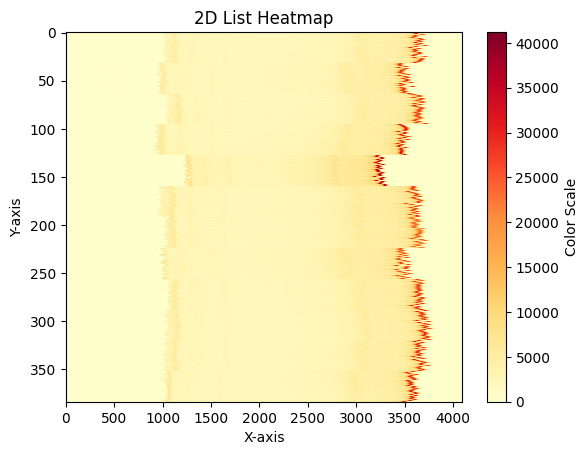

In [27]:
plot_spectra(mca)

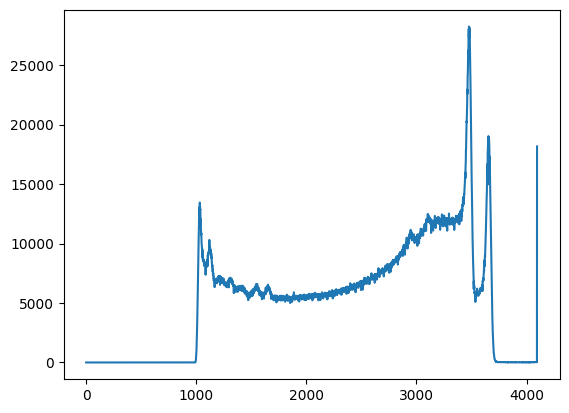

In [50]:
plt.plot(mca[191])
plt.savefig("191.png")

## Multithread processing

In [25]:
    #====================================================================
    # Multiprocessing

    mcas = np.zeros((NUM_CHANS, MCA_SIZE))
    tdcs = np.zeros((NUM_CHANS, TDC_SIZE))

    mp_start_time = time.time()

    files = []

    max_processes  = 8

    files = mp_list_files_in_directory(datafile_dir, filename, run)

    #files = list_files_in_directory(datafile_dir, filename, run)
    pool = multiprocessing.Pool(processes=min(len(files), max_processes))

    for file in files:
        file_full = datafile_dir + '/' + file
        
        result = pool.apply_async(calc_spectra_ret, (file_full, ))
        ret, mca_file, tdc_file = result.get()
        if ret==0:
            mcas = mcas + np.array(mca_file)
            tdcs = tdcs + np.array(tdc_file)

    # Close the pool and wait for all processes to finish
    pool.close()
    pool.join()

    mp_end_time = time.time()

#    mca_np = sum(np.array(mcas))
#    tdc_np = sum(np.array(tdcs))
    print(f'Multithread time: {mp_end_time - mp_start_time}')

ValueError: Number of processes must be at least 1

In [ ]:
directory_path = '/path/to/your/directory'  # Replace with the path to your directory
file_list = []

# List all files in the directory
for filename in os.listdir(datafile_dir):
    if os.path.isfile(os.path.join(datafile_dir, filename) and ):
        file_list.append(filename)

In [26]:
mca_tmp = [[0 for _ in range(MCA_SIZE)] for _ in range(NUM_CHANS)]
tdc_tmp = [[0 for _ in range(TDC_SIZE)] for _ in range(NUM_CHANS)]
calc_spectra("/data/2023/10/25/data.0000000111.0000002210.bin", mca_tmp, tdc_tmp)

FileNotFoundError: [Errno 2] No such file or directory: '/data/2023/10/25/data.0000000111.0000002210.bin'

In [ ]:
            os.rename(datafile_dir + '/' + file, datafile_dir + '/bad/' + file)

In [41]:
print(datafile_dir + '/' + file)
print(datafile_dir + '/bad/' + file)

/data/2023/10/25//data/2023/10/25/data.0000000111.0000002210.bin
/data/2023/10/25/bad//data/2023/10/25/data.0000000111.0000002210.bin


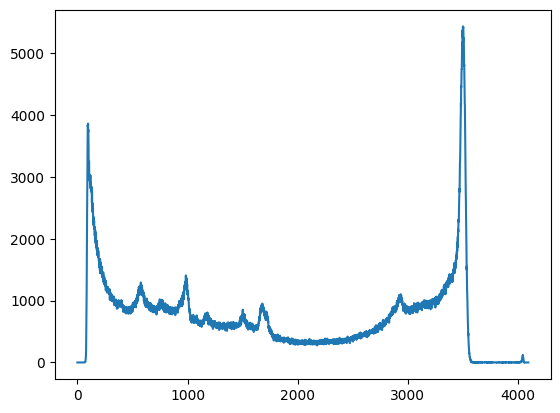

In [17]:
plt.plot(mca[100])

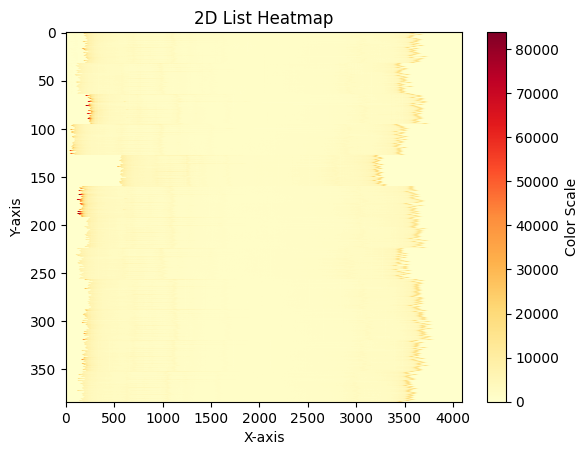

In [27]:
    plot_spectra(mca)

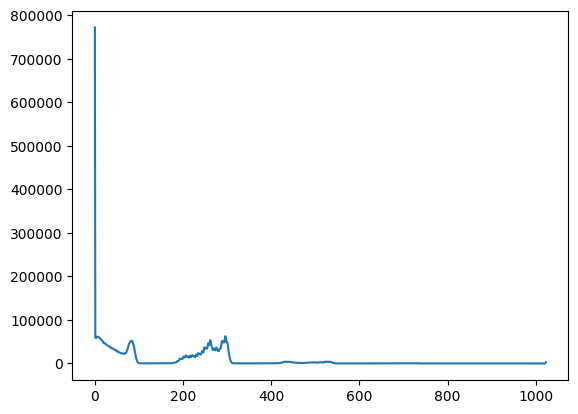

In [25]:
    plt.plot(tdc[100])

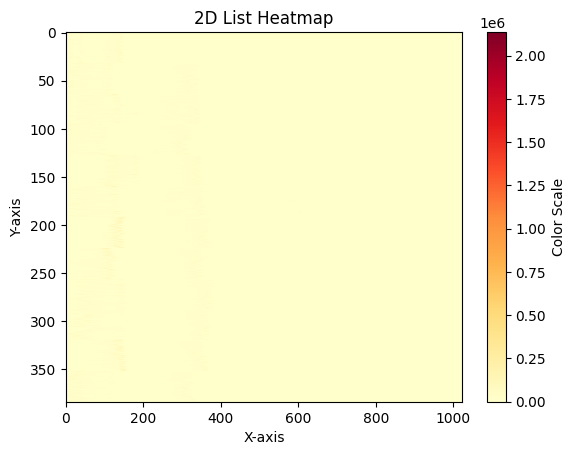

In [18]:
    plot_spectra(tdc)

#### Overall timestamp analysis

In [ ]:
    # analyze overall timestamps
    time_analysis(metadata, timestamps, min_interval, max_interval, time_diff)

In [ ]:
    #  plot timestamps
    ts = [d['timestamp'] for d in metadata]
    plt.plot(ts)
    

### Function: calc_spectra_ret

In [ ]:
    # plot time difference
    plt.plot(time_diff)

#### Timestamp analysis per address

In [ ]:
    # analyze timestamps per addresses
    time_addr_analysis(metadata_addr)

In [ ]:
    chip = 0
    chan = 0
    for chip in range(NUM_CHIPS):
        for chan in range(NUM_CHIP_CHANS):
            print(f'[{chip}][{chan}]:')
            pp = [d['pd'] for d in metadata_addr[chip][chan]]
            for i, p in enumerate(pp):
                if p==0:
                    print(metadata_addr[chip][chan][i]['timestamp'])

In [ ]:
    num_cores = int(mp.cpu_count())
    pool = mp.Pool(num_cores)

    for i, (tt, ll, dd) in enumerate(zip(timestamps_addr, lengths_addr, time_diff_addr)):
        for j, (t, l, d) in enumerate(zip(tt, ll, dd)):
            pool.apply_async(ind_time_analysis, (i, j,
                                                 timestamps_addr[i][j], 
                                                 lengths_addr[i][j], 
                                                 time_diff_addr[i][j],
                                                 min_same_addr_interval,))

## Plot

### MCA

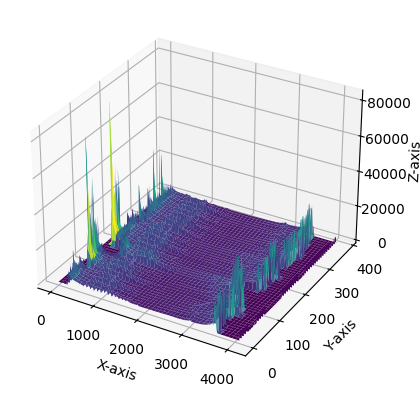

In [51]:


# Create a 2D list (z-values)
data = [
    [1, 2, 3, 4, 5],
    [2, 4, 6, 8, 10],
    [5, 4, 3, 2, 1]
]

# Convert the 2D list to a NumPy array
data = np.array(mca)

# Create x and y values (assuming they are consecutive integers)
x = np.arange(len(data[0]))
y = np.arange(len(data))

# Create a mesh grid for x and y using NumPy
X, Y = np.meshgrid(x, y)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D surface
ax.plot_surface(X, Y, data, cmap='viridis')

# Add labels
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

# Show the plot
#plt.show()
plt.savefig(df_dir + '/mca.svg')
plt.savefig(df_dir + '/mca.pdf', format='pdf')

In [32]:
plt.savefig('/data/2023/10/25/mca.svg')

<Figure size 640x480 with 0 Axes>

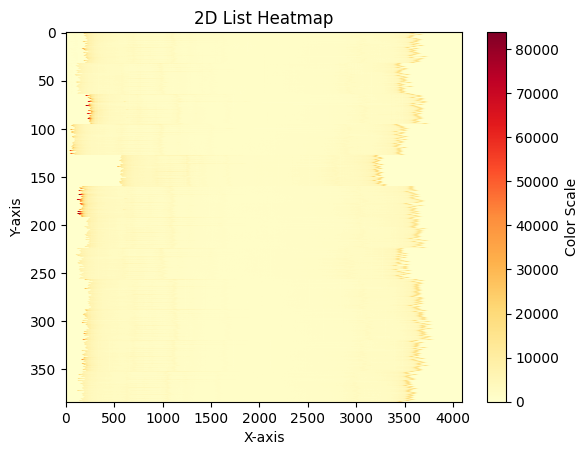

In [52]:
# Convert the 2D list to a NumPy array for better compatibility
data = np.array(mca)

# Create a heatmap using Matplotlib
plt.imshow(data, cmap='YlOrRd', interpolation='nearest', aspect='auto')
plt.colorbar(label='Color Scale')

# Optionally, add axis labels and a title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D List Heatmap')

# Show the heatmap
plt.show()

### TDC

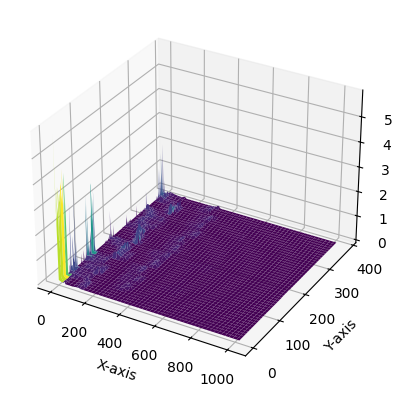

In [36]:
data = np.array(tdc)

# Create x and y values (assuming they are consecutive integers)
x = np.arange(len(data[0]))
y = np.arange(len(data))

# Create a mesh grid for x and y using NumPy
X, Y = np.meshgrid(x, y)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D surface
ax.plot_surface(X, Y, data, cmap='viridis')

# Add labels
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

# Show the plot
#plt.show()
plt.savefig(df_dir + '/tdc.svg')
plt.savefig(df_dir + '/tdc.pdf', format='pdf')

### Disregard the following

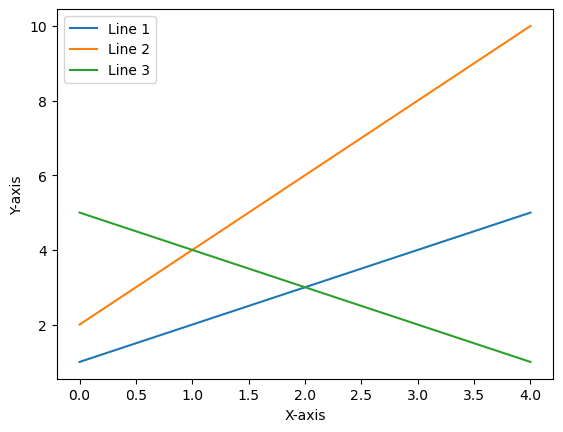

In [50]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

data = [
    [1, 2, 3, 4, 5],
    [2, 4, 6, 8, 10],
    [5, 4, 3, 2, 1]
]

# Create x values (assuming they are consecutive integers)
x = list(range(len(data[0])))

# Plot the data
for row in data:
    plt.plot(x, row)

# Add labels and a legend
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend(["Line 1", "Line 2", "Line 3"])

# Show the plot
plt.show()

## Write data to files

In [54]:
with open(df_dir + '/mca.dat', 'w') as fp:
    fp.write('data ' + str(NUM_CHANS * MCA_SIZE)+ ' ')
    for line in mca:
        for val in line:
            fp.write(str(val) + ' ')

with open(df_dir + '/tdc.dat', 'w') as fp:
    fp.write('data ' + str(NUM_CHANS * TDC_SIZE)+ ' ')
    for line in tdc:
        for val in line:
            fp.write(str(val) + ' ')

## Process data in parallel